In [28]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\K S Ananth\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
import requests, gzip, os, hashlib, tempfile
import numpy as np

def fetch(url):
    # Use tempfile to get a temporary directory
    temp_dir = tempfile.gettempdir()
    fp = os.path.join(temp_dir, hashlib.md5(url.encode('utf-8')).hexdigest())

    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]


In [4]:
X_train.reshape(-1, 28*28).shape

(60000, 784)

(<matplotlib.image.AxesImage at 0x16c4159fe50>, 5)

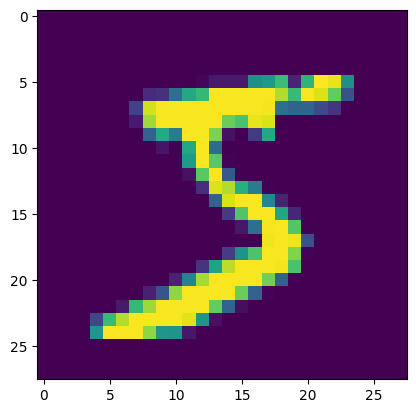

In [5]:
imshow(X_train[0]), Y_train[0]

In [6]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
class BobNet(torch.nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        self.sm = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x

loss 0.19 accuracy 0.93: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.29it/s]


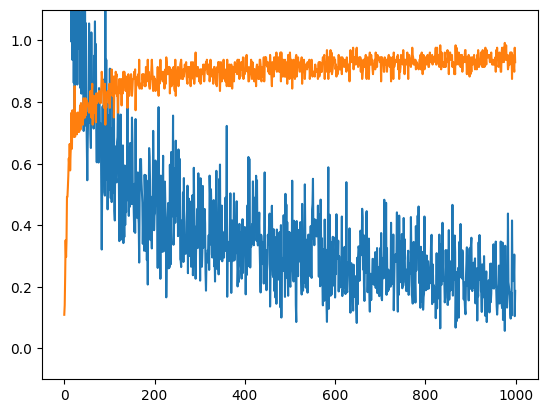

In [7]:
# training
model = BobNet()
BS = 128
losses, accuracies = [], []
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
for i in (t:=trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    model.zero_grad()
    Y = torch.tensor(Y_train[samp]).long()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [8]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test_preds == Y_test).mean()

0.9288

tensor([1.7762e-05], grad_fn=<NllLossBackward0>)


tensor([[ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

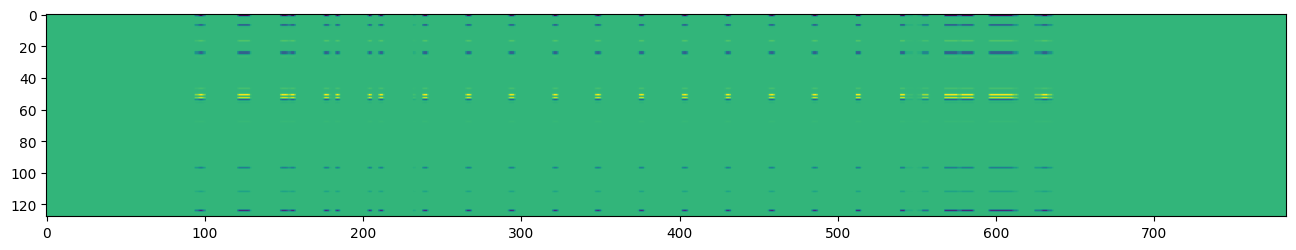

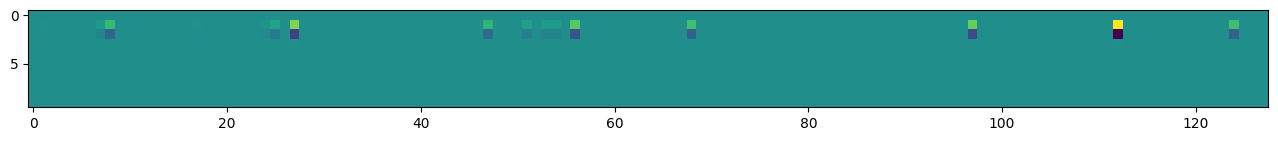

In [9]:
# Understanding gradients
model.zero_grad()
out = model(torch.tensor(X_test[1:2].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[1:2]).long())
print(loss)
loss.retain_grad()
loss.backward()
figsize(16, 16)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

out.grad

In [10]:
# init the network
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
id(l1), id(l2)

(1564702735216, 1564703424112)

In [11]:
# copy weights from pytorch
l1[:] = model.l1.weight.detach().numpy().T #transpose
l2[:] = model.l2.weight.detach().numpy().T #transpose

In [12]:
# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test_preds == Y_test).mean()

0.9292

In [13]:
Y_test_preds_out[0]

array([ -3.4380836 , -12.547048  ,   9.171288  ,   7.6126537 ,
        -2.6878502 ,   0.29501674,  -4.607337  ,  19.826418  ,
         2.6391728 ,   6.203747  ], dtype=float32)

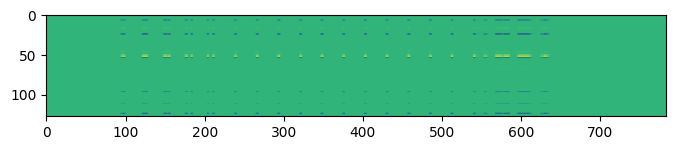

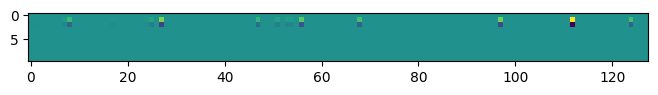

In [31]:
samp = [1]
# training in numpy

#backward pass
out = np.zeros((1, 10), np.float32)
out[range(out.shape[0]), Y_test[samp]] = 1

#forward pass
x = X_test[samp].reshape((-1, 28*28))
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)
# W=x.relu(1, 128), x=l2(128,10)
x_l2 = x_relu.dot(l2)
x_lsm = x_l2 - np.log(np.exp(x_l2).sum(axis=1))
x_loss = (-out * x_lsm).mean(axis=1)

# #will involve x_lsm, x_l2, out and produce dx_sm 
# out = torch.tensor(out)
# gin = torch.tensor(x_l2, requires_grad = True)
# gout = torch.nn.functional.log_softmax(gin, dim=1)
# print(gout)
# loss = (-out*gout).mean()
# loss.backward()
# dx_lsm = gin.grad.numpy()

d_out = -out/10
dx_lsm = d_out - np.exp(x_lsm)*d_out.sum()

#derivative of l2
d_l2 = x_relu.T.dot(dx_lsm)
dx_relu = dx_lsm.dot(l2.T)

#derivative of relu
dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

#derivative of l1
d_l1 = x.T.dot(dx_l1)

imshow(d_l1.T)
figure()
imshow(d_l2.T)

# out
# ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

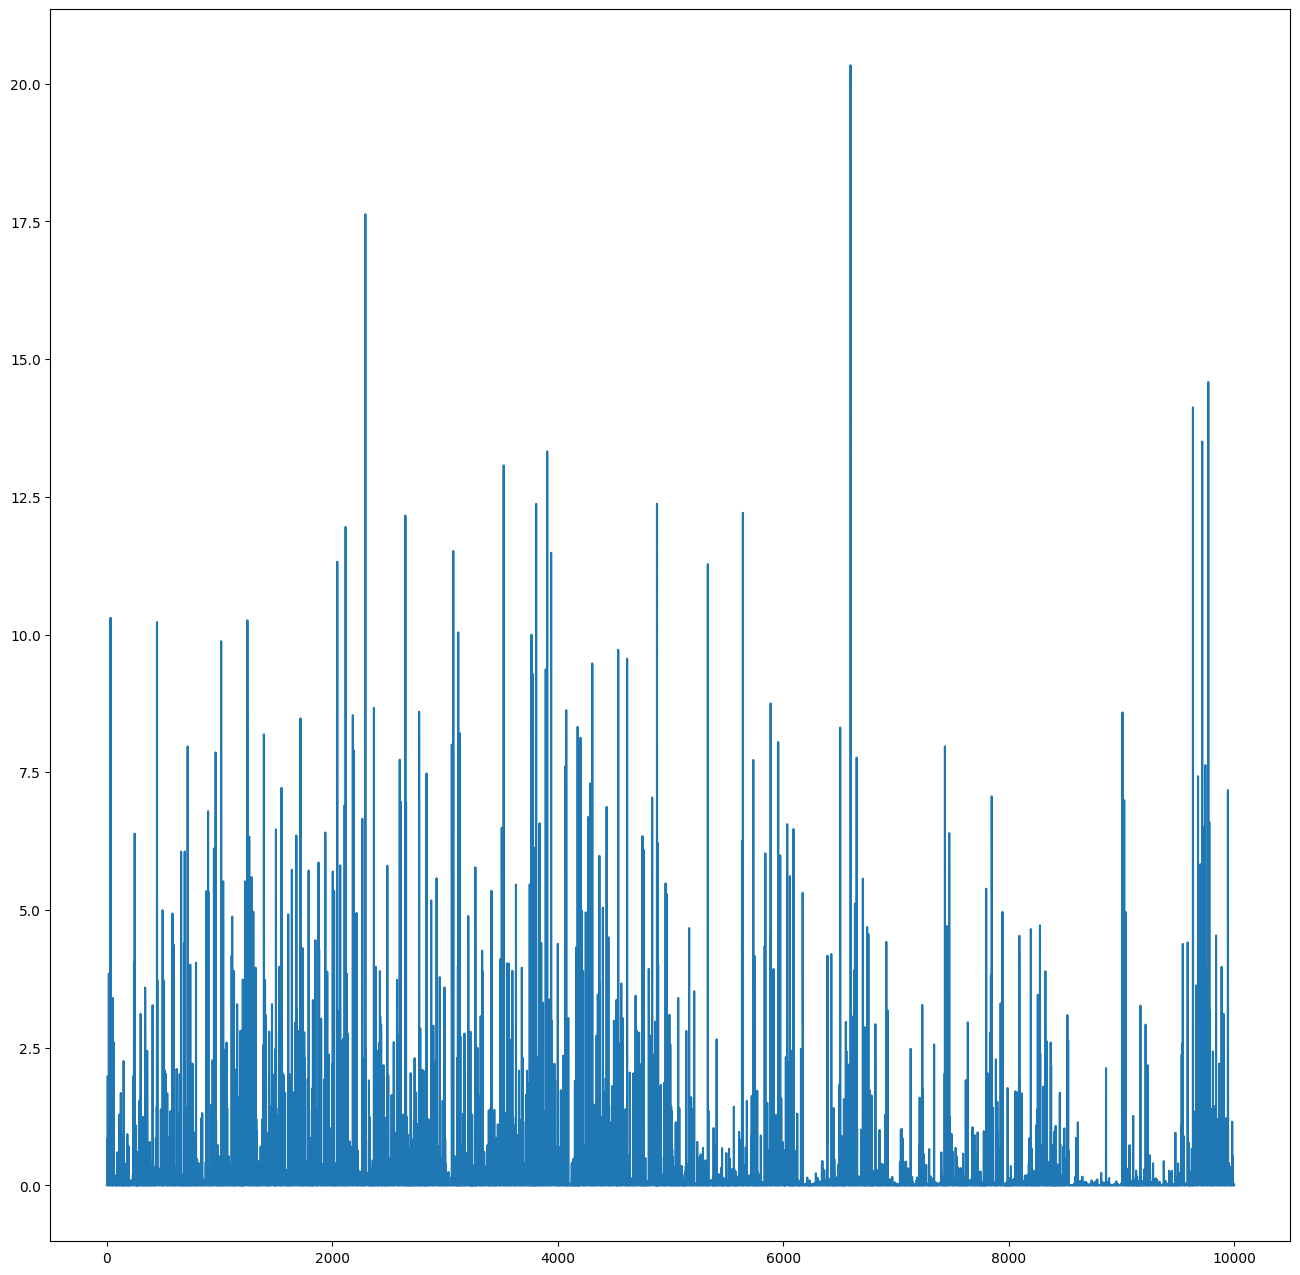

In [18]:
plot(ret)

(<matplotlib.image.AxesImage at 0x16c567a80d0>, 0)

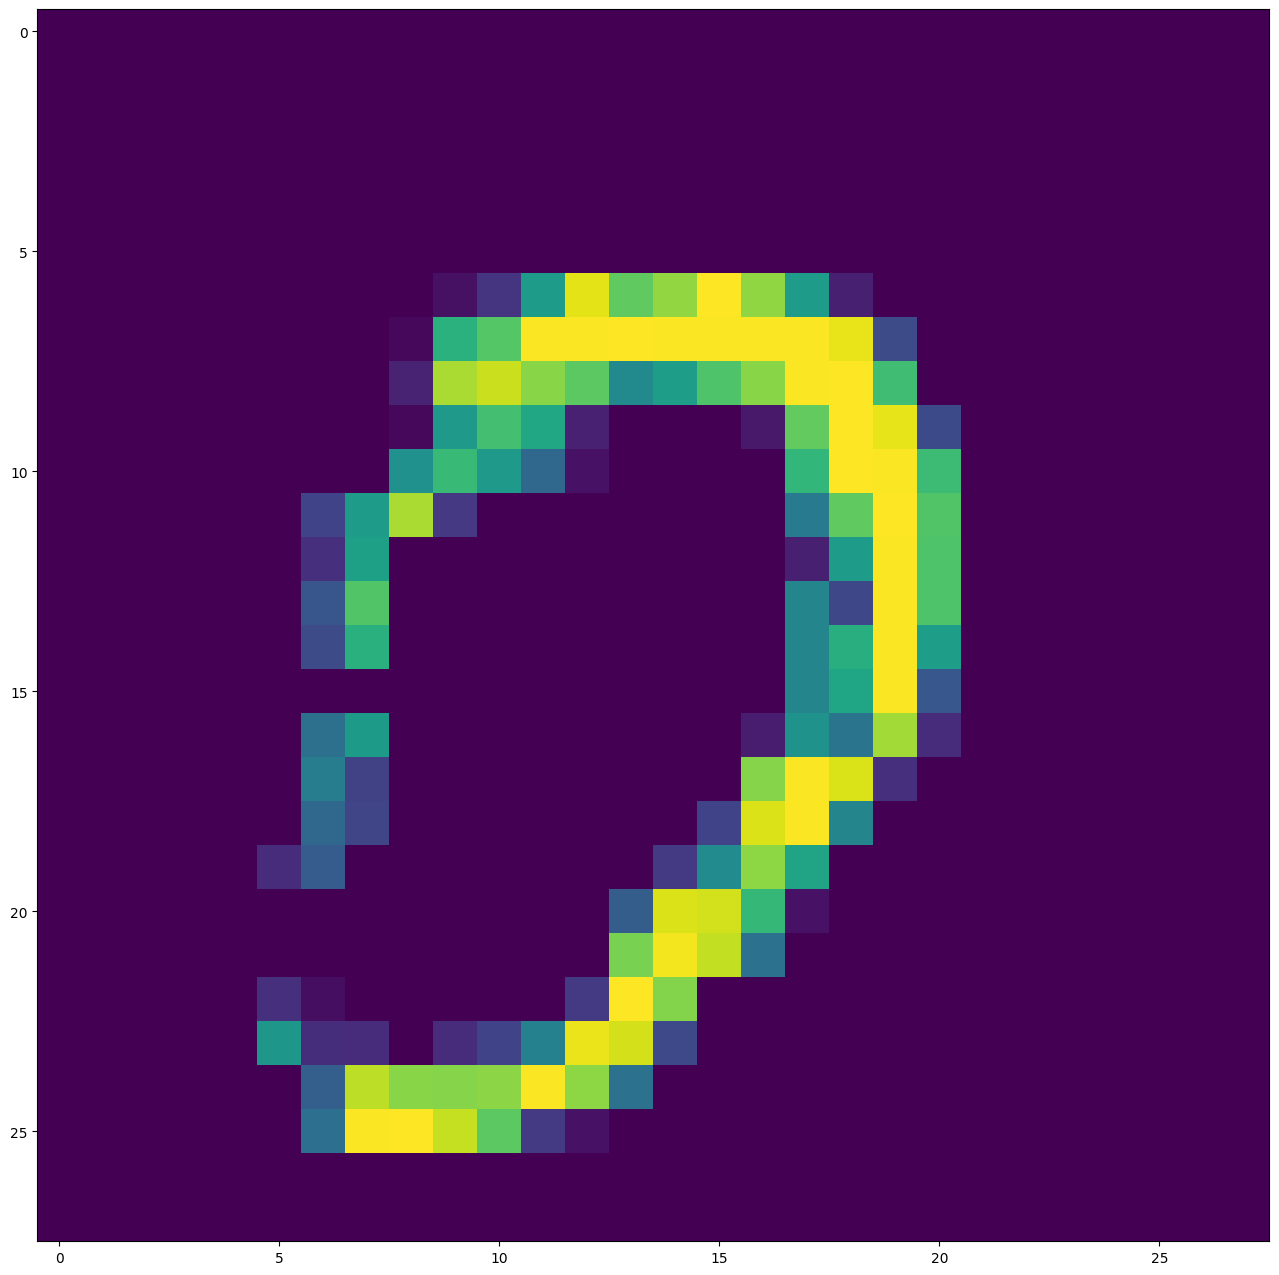

In [19]:
imshow(X_test[np.argmax(ret)]), Y_test[np.argmax(ret)]

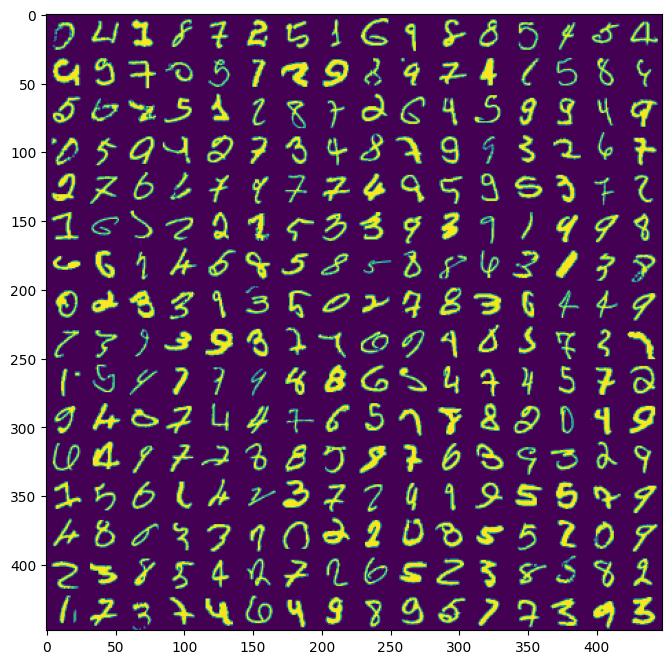

In [20]:
temp = 16

grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:temp*temp]
X_bad = X_test[[x[1] for x in grid]]
figsize(8, 8)
imshow(np.concatenate(X_bad.reshape((temp, 28*temp, 28)), axis=1))